This script shows pcolors of time average quantities 

In [1]:
cd("/scratch/bcpi/cliu28/internal-tide-mixing/")
using Printf
using CairoMakie
using NCDatasets
using Statistics
using NaNStatistics

In [2]:
simname = "tilt"
tᶠ = 460
fname = string("output/",simname,"/internal_tide_theta=0.0036_Nx=500_Nz=250_tᶠ=460_threeD_timeavg_const_dt_Bbudget-wb-eps-chi.nc")
ds = Dataset(fname)
fname = string("output/",simname,"/internal_tide_theta=0.0036_Nx=500_Nz=250_tᶠ=460_threeD_timeavg_B-c.nc")
ds_B = Dataset(fname)


Dataset: output/tilt/internal_tide_theta=0.0036_Nx=500_Nz=250_tᶠ=460_threeD_timeavg_B-c.nc
Group: /

Dimensions
   zC = 250
   zF = 251
   xC = 500
   yF = 1000
   xF = 500
   yC = 1000
   time = 10

Variables
  zC   (250)
    Datatype:    Float64 (Float64)
    Dimensions:  zC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the z-direction.

  zF   (251)
    Datatype:    Float64 (Float64)
    Dimensions:  zF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the z-direction.

  xC   (500)
    Datatype:    Float64 (Float64)
    Dimensions:  xC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the x-direction.

  yF   (1000)
    Datatype:    Float64 (Float64)
    Dimensions:  yF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the y-direction.

  xF   (500)
    Data

In [ ]:
include("../functions/mmderiv.jl")
j=250
t = ds["time"][:]
xC = ds["xC"][:]
zC = ds["zC"][:]
yC = ds["yC"][:]

In [ ]:
ε = dropdims(mean(ds["ε"][:,j,:,:], dims=3),dims=3)
ε[ε .== 0] .= NaN
Bz = zeros(length(xC), length(zC))
for i in 1:length(t)
    B = ds_B["B"][:,j,:,i]
    Bz += mmderiv(zC, B')'
end
Bz ./= length(t)
χ = dropdims(mean(ds["χ"][:,j,:,:], dims=3),dims=3)
χ ./= Bz
χ[isnan.(ε)] .= NaN
χ[χ .< 0] .= 0

In [ ]:
# Squeeze the dimensions to convert to 2D arrays
# Create figure with two subplots
fig = Figure(size = (600, 500))

# Create the heatmap for epsilon
ax1 = Axis(fig[1, 1], 
    # title = "Dissipation Rate (ε)", 
    xlabel = "x [km]", 
    ylabel = "z [m]", 
    xlabelsize = 20, 
    xticklabelsize = 20,
    yticklabelsize = 20,
    ylabelsize = 20,
    xticks = LinearTicks(6),
    yticks = LinearTicks(6),
    xminorticksvisible = true,
    yminorticksvisible = true,
    xminorgridvisible = true,
    yminorgridvisible = true,
    )
ax2 = Axis(fig[2, 1], 
    # title = "Buoyancy variance dissipation rate (χ)", 
    xlabel = "x [km]", 
    ylabel = "z [m]", 
    xlabelsize = 20, 
    xticklabelsize = 20,
    yticklabelsize = 20,
    ylabelsize = 20,
    xticks = LinearTicks(6),
    yticks = LinearTicks(6),
    xminorticksvisible = true,
    yminorticksvisible = true,
    xminorgridvisible = true,
    yminorgridvisible = true,    
    )
hm1 = heatmap!(ax1, xC/1e3, zC, ε, colormap = :thermal, colorscale = log10, 
    colorrange = (10^(-10), 10^(-6)), nan_color = :gray)
cb1 = Colorbar(fig[1, 2], hm1, label = L"log_{10}(ε̄)", labelsize = 20, ticklabelsize = 20, 
    ticks = ([1e-10, 1e-9, 1e-8, 1e-7, 1e-6], ["-10", "-9", "-8", "-7", "-6"])
)

# Create the heatmap for chi
hm2 = heatmap!(ax2, xC/1e3, zC, χ, colormap = :thermal, colorscale = log10, 
    colorrange = (10^(-10), 10^(-6)), nan_color = :gray)
cb2 = Colorbar(fig[2, 2], hm2, label = L"log_{10}(χ̄)", labelsize = 20, ticklabelsize = 20,
    ticks = ([1e-10, 1e-9, 1e-8, 1e-7, 1e-6], ["-10", "-9", "-8", "-7", "-6"])
)
j=500
save(string("output/",simname,"/ε-χ-10TPavg_y=",round(yC[j]/1e3),".png"),fig)
fig

Here, showing the average at each tidal phases would reveal useful information associated with certain phases.
First let's plot the spanwise-averaged streamfunction. 

In [ ]:
using NCDatasets
using NaNStatistics
simname = "tilt"
tᶠ=460
θ = simname == "tilt" ? 0.0036 : 0
# load data
filename_field = string("output/", simname, "/internal_tide_theta=",θ,"_Nx=500_Nz=250_tᶠ=",tᶠ, "_threeD_u-v-w-c.nc")
ds_field = Dataset(filename_field,"r")
zC = ds_field["zC"][:]; zF = ds_field["zF"][:];
Nz=length(zC[:]);       dz = abs.(zF[1:end-1]-zF[2:end])

xC = ds_field["xC"][:]; xF = ds_field["xF"][:]; 
Nx=length(xC[:]);       dx = xF[end]-xF[end-1];

yC = ds_field["yC"][:]; yF = ds_field["yF"][:]
Ny=length(yC[:]);       dy = yF[end]-yF[end-1];
Ly = yF[end]+dy
t = ds_field["time"][:];
U = zeros(Nx,Nz,6)
W = zeros(Nx,Nz,6)

n=1
uhat = nansum(nanmean(ds_field["uhat"][:,:,:,12:12:120],dim=(4))*dy,dim=2);    # true u (integral)
what = nansum(nanmean(ds_field["what"][:,:,:,12:12:120],dim=(4))*dy,dim=2);    # true w (integral)
what_cen = (what[:,1:end-1] .+ what[:,2:end])./2 # what at center
# piecewise linear interpolation of what_cen from [center,center,center] to [face,center,center]
wtemp = (vcat(what_cen[end:end,:],what_cen[1:end-1,:]) .+ what_cen[:,:])./2
U[:,:,n] = (uhat[:,:]*cos(θ) .+ wtemp*sin(θ)) # cross-slope velocity transport
W[:,:,n]= (-uhat[:,:]*sin(θ) .+ wtemp*cos(θ))# slope-normal velocity transport
ni = 3:2:11
for n in 1:length(ni)
    uhat = zeros(Nx,Nz)
    what = zeros(Nx,Nz+1)
    for i in 1:10
        uhat += nansum(ds_field["uhat"][:,:,:,12i-(12-(ni[n]-1))]*dy,dim=2);    # true u (integral)
        what += nansum(ds_field["what"][:,:,:,12i-(12-(ni[n]-1))]*dy,dim=2);    # true w (integral)
        @info i
    end
    uhat ./= 10
    what ./= 10
    what_cen = (what[:,1:end-1] .+ what[:,2:end])./2 # what at center
    # piecewise linear interpolation of what_cen from [center,center,center] to [face,center,center]
    wtemp = (vcat(what_cen[end:end,:],what_cen[1:end-1,:]) .+ what_cen[:,:])./2
    U[:,:,n+1] = (uhat[:,:]*cos(θ) .+ wtemp*sin(θ)) # cross-slope velocity transport
    W[:,:,n+1]= (-uhat[:,:]*sin(θ) .+ wtemp*cos(θ)) # slope-normal velocity transport
end
ψ = zeros(Nx,Nz,6)
for i in 1:Nx
    for j in 2:Nz
        ψ[i,j,:] = ψ[i,j-1,:] .- U[i,j-1,:]*dz[j]
    end
end

ψ[U.==0].=NaN
U[U.==0].=NaN
W[W.==0].=NaN

In [ ]:
# bathymetry
using MAT
using NaNStatistics
file = matopen("topo.mat")
z_topo = read(file, "z_noslope_periodic") 
x_topo = read(file, "x_domain")
y_topo = read(file, "y_domain")
# grids has to be evenly spaced
x_topo_lin = range(x_topo[1],x_topo[end],size(z_topo,1))
y_topo_lin = range(y_topo[1],y_topo[end],size(z_topo,2))
close(file)
# high-resolution grids
Nx = 500
Ny = 1000
x_interp = range(x_topo[1],x_topo[end], length=Nx)
#Ny=2Nx
y_interp = range(y_topo[1],y_topo[end], length=Ny)

using Interpolations
# Interpolation object (caches coefficients and such)
itp = LinearInterpolation((x_topo_lin, y_topo_lin), z_topo)
# Interpolate z_topo onto a higher-resolution grid
itp = LinearInterpolation((x_topo_lin, y_topo_lin), z_topo)
z_interp = [itp(x_topo_lin, y_topo_lin) for x_topo_lin in x_interp, y_topo_lin in y_interp]
z_interp = z_interp.-minimum(z_interp)
z_interp_y = nanmean(z_interp,dim=2)


In [ ]:
# This creates a new NetCDF file 
Nt=6
simname = "tilt"
ds_create = Dataset(string("output/",simname,"/streamfunction_tidal_phase_average.nc"),"c")
# Define the dimension
defDim(ds_create,"x",Nx)
defDim(ds_create,"z",Nz)
defDim(ds_create,"t",Nt)
# Define a global attribute
ds_create.attrib["title"] = "Transport Streamfunction"
# Define the variables
v1 = defVar(ds_create,"ψ",Float64,("x","z","t"))
v1[:,:,:] = ψ
v2 = defVar(ds_create,"U",Float64,("x","z","t"))
v2[:,:,:] = U
v3 = defVar(ds_create,"W",Float64,("x","z","t"))
v3[:,:,:] = W
v4 = defVar(ds_create,"xC",Float64,("x",))
v4[:] = xC[:]
v5 = defVar(ds_create,"zC",Float64,("z",))
v5[:] = zC[:]


# write attributes
v1.attrib["units"] = "m³/s"
v2.attrib["units"] = "m²/s"
v3.attrib["units"] = "m²/s"
v4.attrib["units"] = "m"
v5.attrib["units"] = "m"
close(ds_create)

In [ ]:
# plot
using NCDatasets
using PyPlot
simname = "tilt"
filename = string("output/",simname,"/streamfunction_tidal_phase_average.nc")
ds = Dataset(filename)
ψ = ds["ψ"][:,:,:]
U = ds["U"][:,:,:]
W = ds["W"][:,:,:]
xC = ds["xC"][:]/1e3
zC = ds["zC"][:]

# Font size settings
SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# Set font sizes globally - using consistent quote style
plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)  # Changed from 'xtick' to "xtick"
plt.rc("ytick", labelsize=SMALL_SIZE)  # Changed from 'ytick' to "ytick"
plt.rc("legend", fontsize=SMALL_SIZE)  # Changed from 'legend' to "legend"

# Find suitable color ranges for consistent colormaps across subplots
psi_min, psi_max = extrema(filter(!isnan, ψ))
U_min, U_max = extrema(filter(!isnan, U))
W_min, W_max = extrema(filter(!isnan, W))

# Skip indices for quiver plots to avoid overcrowding
x_skip = 12
z_skip = 6

# Create figures with space for colorbars
fig_psi = plt.figure(figsize=(20, 12))
fig_U = plt.figure(figsize=(20, 12))
fig_W = plt.figure(figsize=(20, 12))

# Initialize im_psi, im_U, im_W variables to store the last plot objects
im_psi = nothing
im_U = nothing
im_W = nothing

# Create subplots for each timestep (6 timesteps total)
for (i, timestep) in enumerate(2:6)
    # Streamfunction plot
    ax_psi = fig_psi.add_subplot(2, 3, i)
    im_psi = ax_psi.pcolormesh(xC, zC, ψ[:,:,timestep]', cmap="GnBu", vmin=psi_min, vmax=psi_max)
    
    ax_psi.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    
    # Add quiver plot to streamfunction
    x_quiver = xC[1:x_skip:end]
    z_quiver = zC[1:z_skip:end]
    u_quiver = U[1:x_skip:end,1:z_skip:end,timestep]'
    w_quiver = W[1:x_skip:end,1:z_skip:end,timestep]'
    ax_psi.quiver(x_quiver, z_quiver, u_quiver, w_quiver, angles="xy", scale_units="xy")
    
    ax_psi.set_xlabel("x (km)")
    ax_psi.set_ylabel("z (m)")
    ax_psi.set_title("ψ, timestep $timestep")
    ax_psi.set_facecolor("gray")

    # U velocity plot
    ax_U = fig_U.add_subplot(2, 3, i)
    im_U = ax_U.pcolormesh(xC, zC, U[:,:,timestep]', cmap="RdBu_r", vmin=U_min, vmax=U_max)
    
    ax_U.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    ax_U.set_xlabel("x (km)")
    ax_U.set_ylabel("z (m)")
    ax_U.set_title("U, timestep $timestep")
    ax_U.set_facecolor("gray")

    # W velocity plot
    ax_W = fig_W.add_subplot(2, 3, i)
    im_W = ax_W.pcolormesh(xC, zC, W[:,:,timestep]', cmap="RdBu_r", vmin=W_min, vmax=W_max)
    
    ax_W.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    ax_W.set_xlabel("x (km)")
    ax_W.set_ylabel("z (m)")
    ax_W.set_title("W, timestep $timestep")
    ax_W.set_facecolor("gray")
end

# Add colorbars to the right side of each figure
plt.figure(fig_psi.number)
plt.tight_layout()
cbar_ax = fig_psi.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig_psi.colorbar(im_psi, cax=cbar_ax)
cbar.set_label("ψ (m³/s)", fontsize=MEDIUM_SIZE)
cbar.ax.tick_params(labelsize=SMALL_SIZE)

plt.figure(fig_U.number)
plt.tight_layout()
cbar_ax = fig_U.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig_U.colorbar(im_U, cax=cbar_ax)
cbar.set_label("U (m²/s)", fontsize=MEDIUM_SIZE)
cbar.ax.tick_params(labelsize=SMALL_SIZE)

plt.figure(fig_W.number)
plt.tight_layout()
cbar_ax = fig_W.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig_W.colorbar(im_W, cax=cbar_ax)
cbar.set_label("W (m²/s)", fontsize=MEDIUM_SIZE)
cbar.ax.tick_params(labelsize=SMALL_SIZE)

# Save the figures
fig_psi.savefig(string("output/",simname,"/streamfunction_tidal_phase_average_psi.png"), dpi=300, bbox_inches="tight")
fig_U.savefig(string("output/",simname,"/streamfunction_tidal_phase_average_U.png"), dpi=300, bbox_inches="tight")
fig_W.savefig(string("output/",simname,"/streamfunction_tidal_phase_average_W.png"), dpi=300, bbox_inches="tight")

In [ ]:
fig_W

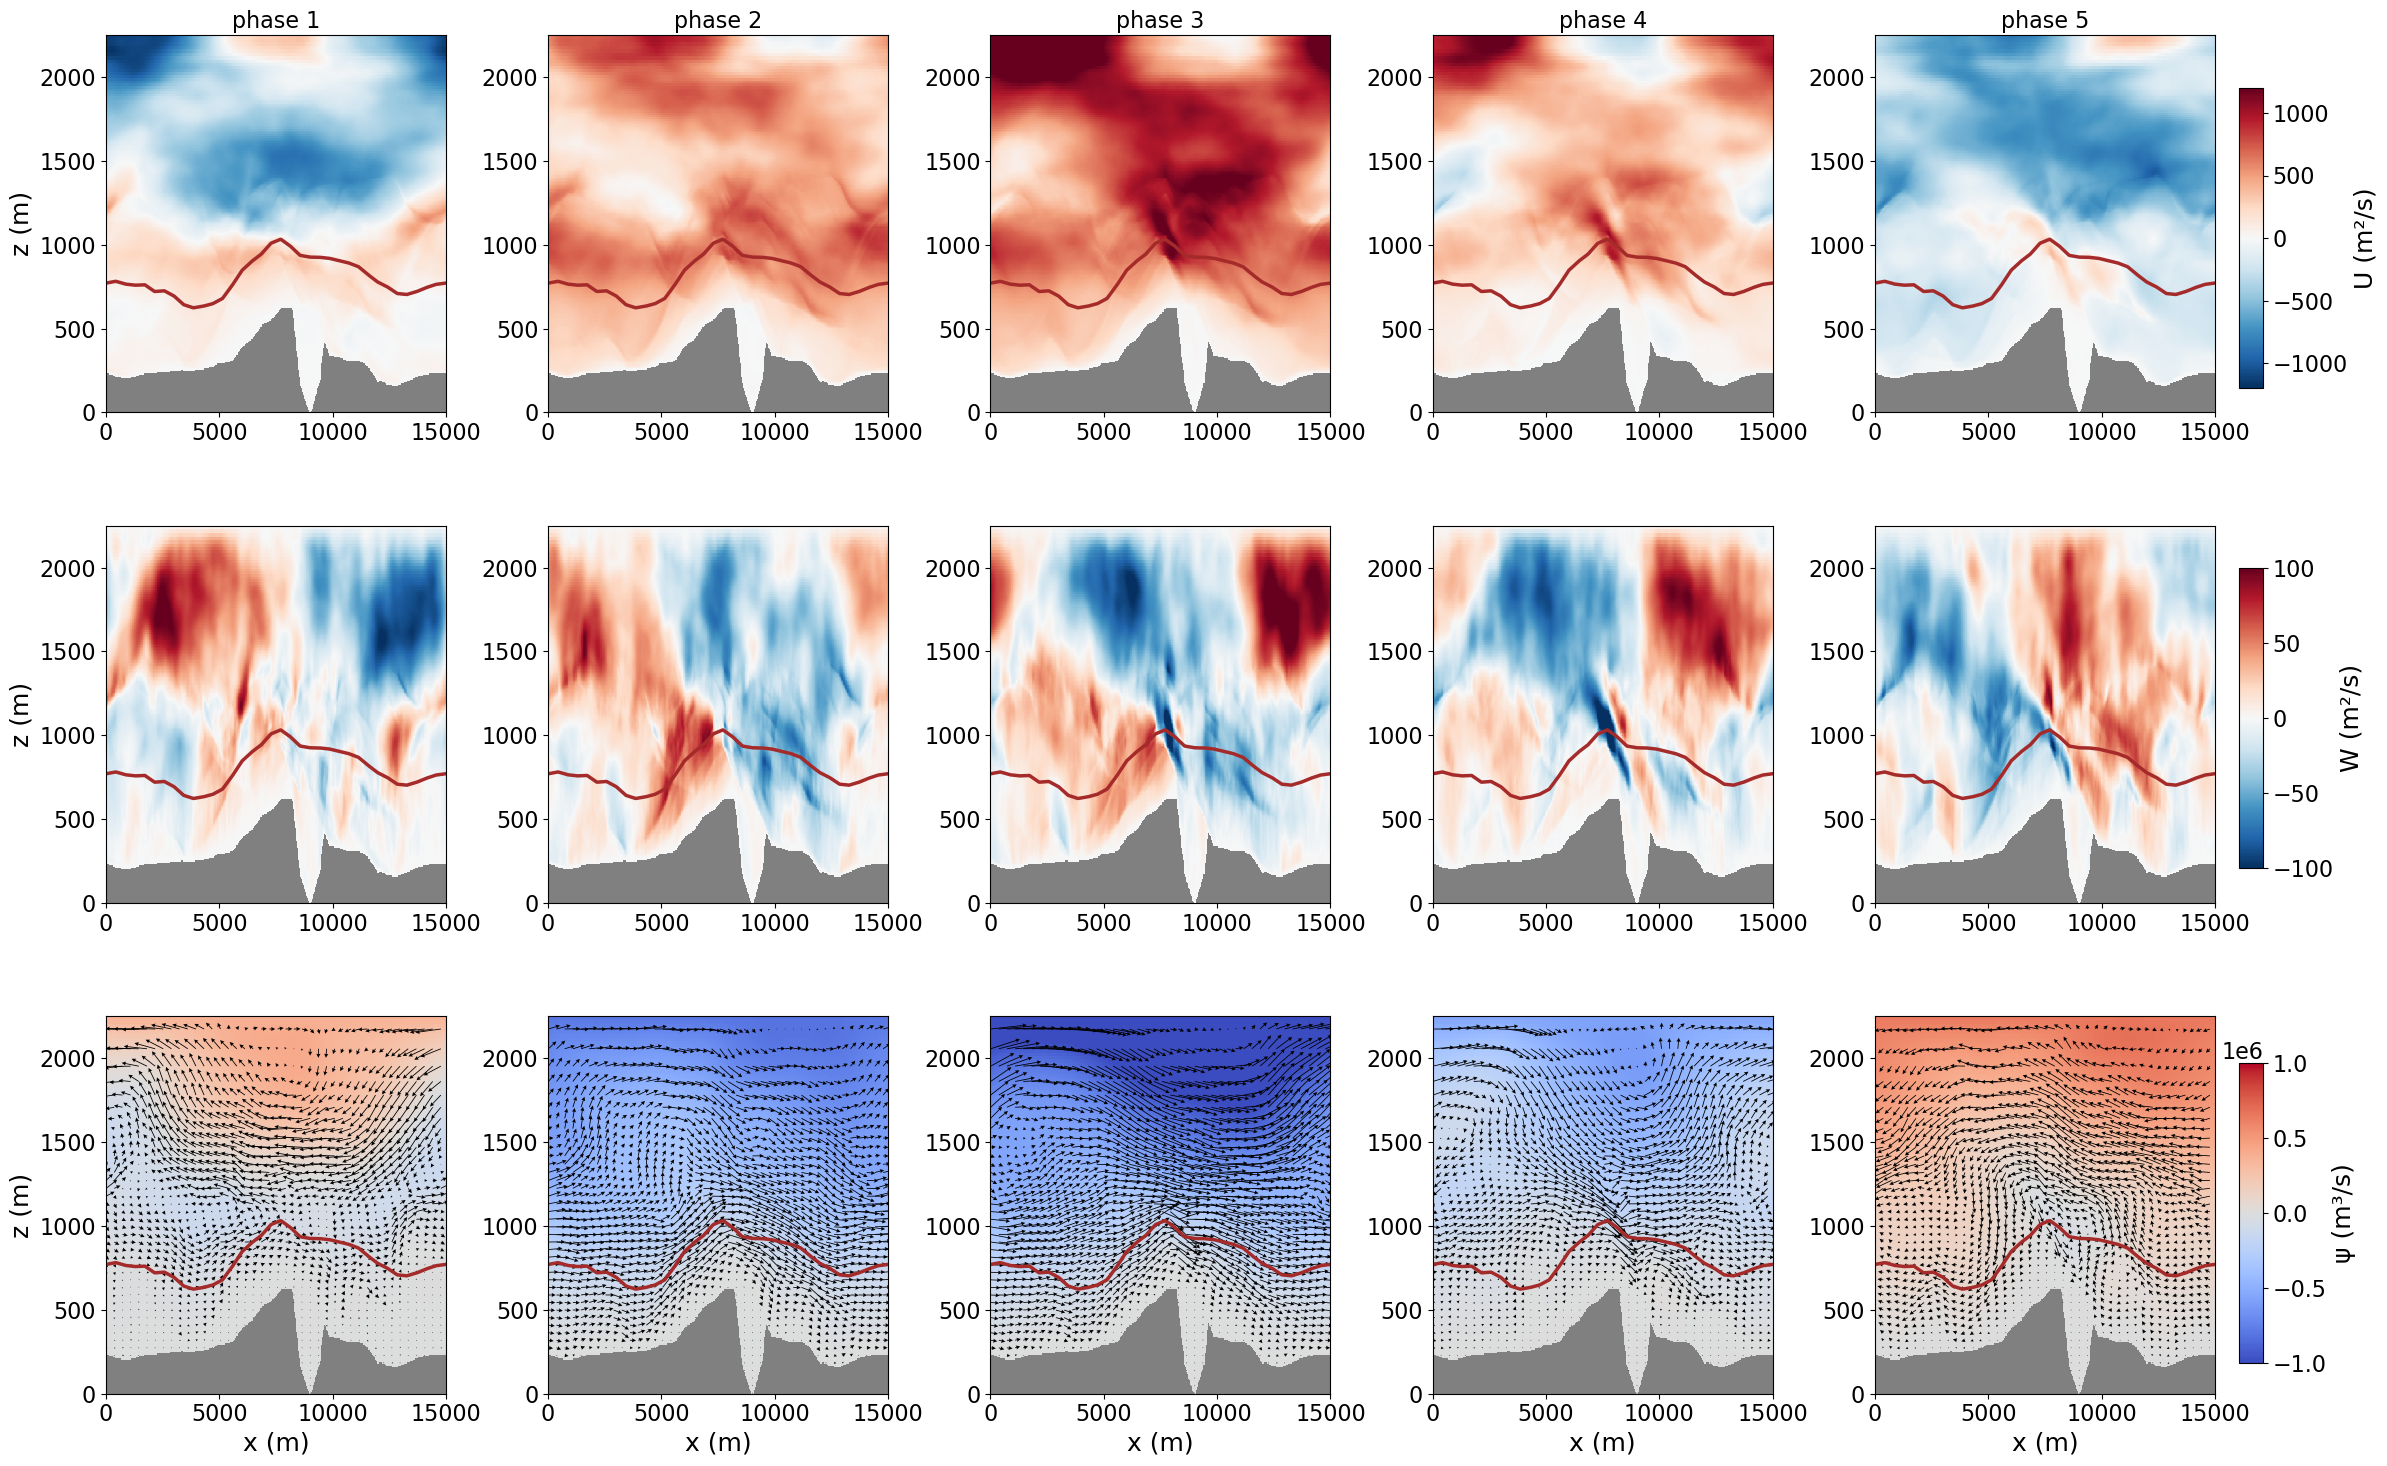

In [94]:
# plot
using NCDatasets
using PyPlot
simname = "tilt"
filename = string("output/",simname,"/streamfunction_tidal_phase_average.nc")
ds = Dataset(filename)
ψ = ds["ψ"][:,:,:]
U = ds["U"][:,:,:]
W = ds["W"][:,:,:]
xC = ds["xC"][:]
zC = ds["zC"][:]

# Font size settings
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

# Set font sizes globally
plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)

# Find suitable color ranges for consistent colormaps across subplots
psi_min, psi_max = extrema(filter(!isnan, ψ))
U_min, U_max = extrema(filter(!isnan, U))
W_min, W_max = extrema(filter(!isnan, W))

# Skip indices for quiver plots to avoid overcrowding
x_skip = 12
z_skip = 6

# Create a single figure with 3x6 subplots (5 for data + 1 for colorbar)
fig = plt.figure(figsize=(24, 15))

# Initialize colorbar artists
im_U = nothing
im_W = nothing
im_psi = nothing

# Create subplots for each timestep (showing timesteps 2-6)
for (idx, timestep) in enumerate(2:6)
    i = idx  # Column index (1-5)
    
    # First row: U velocity plots (timesteps 2-6)
    ax_U = fig.add_subplot(3, 5, i)
    im_U = ax_U.pcolormesh(xC, zC, U[:,:,timestep]', cmap="RdBu_r", vmin=-1200, vmax=1200)
    ax_U.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    
    if i == 1  # Only add y-label to first column
        ax_U.set_ylabel("z (m)")
    end
    
    if i == 3  # Add title to middle subplot
        # ax_U.set_title("Cross-slope velocity (U)", pad=20)
    end
    
    ax_U.set_title("phase $(timestep-1)", fontsize=SMALL_SIZE, pad=5)
    ax_U.set_facecolor("gray")
    
    # Second row: W velocity plots (timesteps 2-6)
    ax_W = fig.add_subplot(3, 5, i + 5)
    im_W = ax_W.pcolormesh(xC, zC, W[:,:,timestep]', cmap="RdBu_r", vmin=-100, vmax=100)
    ax_W.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    
    if i == 1  # Only add y-label to first column
        ax_W.set_ylabel("z (m)")
    end
    
    if i == 3  # Add title to middle subplot
        # ax_W.set_title("Slope-normal velocity (W)", pad=20)
    end
    
    ax_W.set_facecolor("gray")
    
    # Third row: Streamfunction plots with quiver (timesteps 2-6)
    ax_psi = fig.add_subplot(3, 5, i + 10)
    im_psi = ax_psi.pcolormesh(xC, zC, ψ[:,:,timestep]', cmap="coolwarm", vmin=-1e6, vmax=1e6)
    ax_psi.plot(xC, z_interp_y[:], color="brown", linewidth=2.5)
    
    # Add quiver plot to streamfunction
    x_quiver = xC[1:x_skip:end]
    z_quiver = zC[1:z_skip:end]
    u_quiver = U[1:x_skip:end,1:z_skip:end,timestep]'
    w_quiver = W[1:x_skip:end,1:z_skip:end,timestep]'
    ax_psi.quiver(x_quiver, z_quiver, u_quiver, w_quiver, angles="xy", scale_units="xy", scale=1, headwidth=5)
    # ax_psi.quiver(xC[1:12:end],zC[1:6:end], U[1:12:end,1:6:end]', W[1:12:end,1:6:end]',               
    # angles="xy", scale_units="xy")      
    if i == 1  # Only add y-label to first column
        ax_psi.set_ylabel("z (m)")
    end
    
    if i == 3  # Add title to middle subplot
        # ax_psi.set_title("Streamfunction (ψ) with velocity vectors", pad=20)
    end
    
    ax_psi.set_xlabel("x (m)")
    ax_psi.set_facecolor("gray")
end

# Add x-labels to bottom row only
for i in 1:5
    ax = fig.get_axes()[i + 10]  # Access the third row axes
    # ax.set_xlabel("x (m)")
end
# Adjust the layout to make room for colorbars
plt.tight_layout()
plt.subplots_adjust(right=0.93)  # Make room on the right side for colorbars

# Add very thin colorbars positioned manually on the right side
# Calculate positions for each colorbar (left, bottom, width, height)
# U colorbar (top row)
cbar_ax_U = fig.add_axes([0.94, 0.73, 0.01, 0.2])  # Thin! width=0.01
cbar_U = fig.colorbar(im_U, cax=cbar_ax_U)
cbar_U.set_label("U (m²/s)")
cbar_U.ax.tick_params(labelsize=SMALL_SIZE)

# W colorbar (middle row)
cbar_ax_W = fig.add_axes([0.94, 0.41, 0.01, 0.2])  # Thin! width=0.01
cbar_W = fig.colorbar(im_W, cax=cbar_ax_W)
cbar_W.set_label("W (m²/s)")
cbar_W.ax.tick_params(labelsize=SMALL_SIZE)

# ψ colorbar (bottom row)
cbar_ax_psi = fig.add_axes([0.94, 0.08, 0.01, 0.2])  # Thin! width=0.01
cbar_psi = fig.colorbar(im_psi, cax=cbar_ax_psi)
cbar_psi.set_label("ψ (m³/s)")
cbar_psi.ax.tick_params(labelsize=SMALL_SIZE)
# Adjust layout to prevent overlap
# plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Save the figure
fig.savefig(string("output/",simname,"/streamfunction_tidal_phase_average_combined.png"), dpi=300, bbox_inches="tight")
fig

Plot the tidal phases

In [ ]:
using PyPlot
close("all")
# Create a matrix of colors for different tidal phases
colors = [
    [0.8500, 0.3250, 0.0980],  # Burnt orange
    [0.0, 0.4470, 0.7410],     # Blue
    [0.4660, 0.6740, 0.1880],  # Green
    [0.4940, 0.1840, 0.5560],  # Purple
    [0.9290, 0.6940, 0.1250]   # Yellow
]

# Create figure with proper size and DPI
close("all")
plt.figure(figsize=(10, 6), dpi=100)
plt.rc("font", size=20)

pl= plt.plot(t[1:120]/(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,1:120],dim=1), linewidth=2.5, color="black" )
plt.scatter(t[3:12:120]./(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,3:12:120],dim=1), c=colors[1], s=70)
plt.scatter(t[5:12:120]./(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,5:12:120],dim=1), c=colors[2], s=70)
plt.scatter(t[7:12:120]./(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,7:12:120],dim=1), c=colors[3], s=70)
plt.scatter(t[9:12:120]./(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,9:12:120],dim=1), c=colors[4], s=70)
plt.scatter(t[11:12:120]./(2*pi/1.4e-4),nanmean(ds_field["uhat"][250,:,150,11:12:120],dim=1), c=colors[5], s=70)

savefig(string("output/",simname,"/uhat_tidal_phase_average.png"), dpi=300, bbox_inches="tight")